In [2]:
!pip install scikit-learn==1.0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 60.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.29.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.0.2 which is incompatible.


Mounted at /content/drive

Classification Report:
                                                                    precision    recall  f1-score   support

           Category 01: Driving Documentation Compliance Violation       1.00      1.00      1.00        14
        Category 02: Public Safety Breaches from Hazardous Driving       1.00      0.81      0.90        16
  Category 03: Unsafe Vehicle Condition and Road Safety Negligence       0.85      0.79      0.81        14
Category 04: Public Transportation Regulatory Compliance Violation       1.00      1.00      1.00        12

                                                         micro avg       0.96      0.89      0.93        56
                                                         macro avg       0.96      0.90      0.93        56
                                                      weighted avg       0.96      0.89      0.92        56
                                                       samples avg       0.97      0

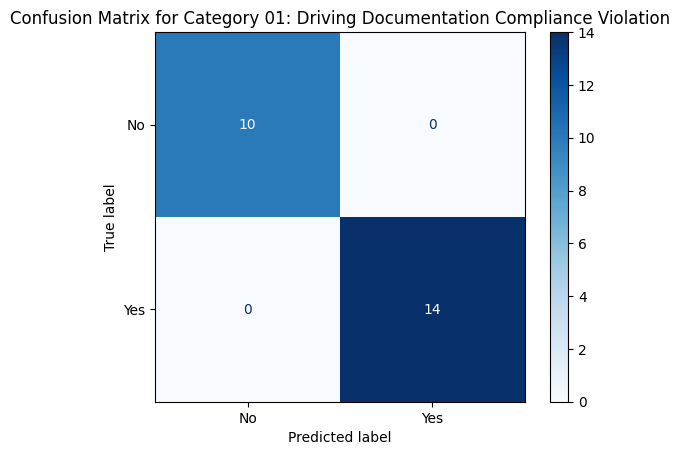

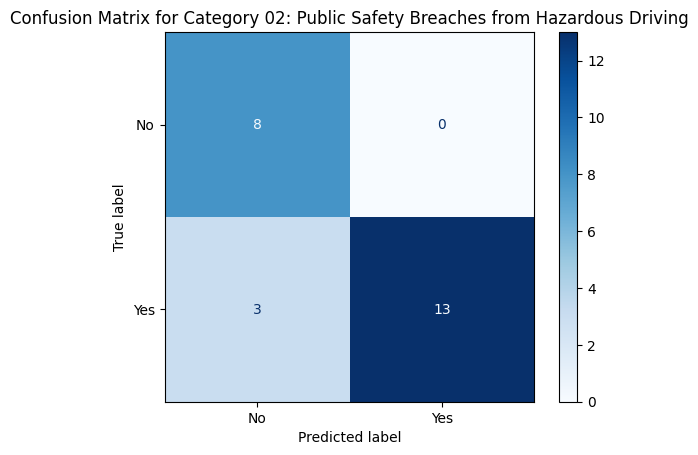

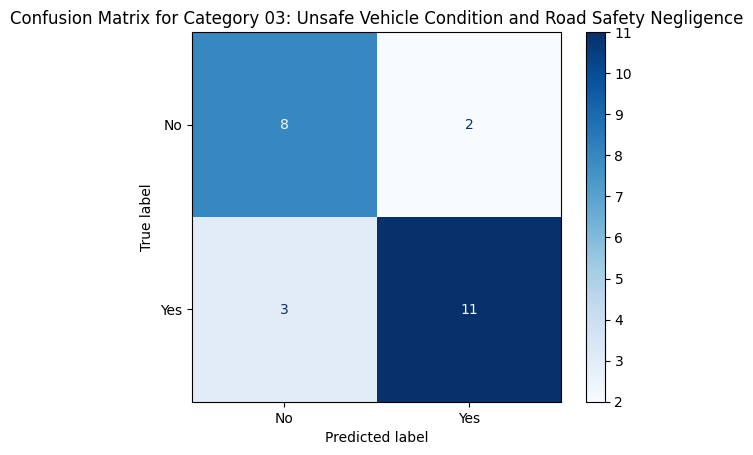

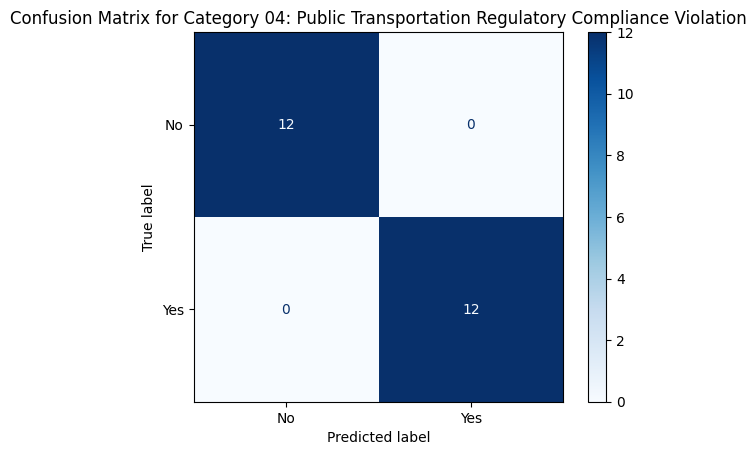

In [8]:
from google.colab import drive
import pandas as pd
import numpy as np
import logging
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Enable logging
logging.basicConfig(level=logging.INFO)

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Load dataset
file_path = '/content/drive/My Drive/MY_RESEARCH/Legal_Strategy_Prediction/EXPERIMENTS/encoded_dataset.csv'
data = pd.read_csv(file_path)

# Clean dataset
data = data.dropna(how='all').dropna(axis=1, how='all')

# Separate features and target variables
X = data.iloc[:, :-4]
y = data.iloc[:, -4:]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize individual classifiers
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
gb_model = GradientBoostingClassifier(random_state=42)
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

# Hyperparameter tuning for RandomForest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search_rf.fit(X_train, y_train.iloc[:, 0])  # Tuning on the first label for demonstration
best_rf_params = grid_search_rf.best_params_
logging.info(f"Best RF Parameters: {best_rf_params}")
rf_model.set_params(**best_rf_params)

# Hyperparameter tuning for GradientBoosting
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}
grid_search_gb = GridSearchCV(gb_model, param_grid_gb, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search_gb.fit(X_train, y_train.iloc[:, 0])
best_gb_params = grid_search_gb.best_params_
logging.info(f"Best GB Parameters: {best_gb_params}")
gb_model.set_params(**best_gb_params)

# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train.iloc[:, 0])
best_xgb_params = grid_search_xgb.best_params_
logging.info(f"Best XGB Parameters: {best_xgb_params}")
xgb_model.set_params(**best_xgb_params)

# Create a VotingClassifier
voting_model = VotingClassifier(
    estimators=[('rf', rf_model), ('gb', gb_model), ('xgb', xgb_model)],
    voting='soft'
)

# Multi-label wrapper
multi_label_voting = MultiOutputClassifier(voting_model)

# Fit model
multi_label_voting.fit(X_train, y_train)

# Predict
y_pred = multi_label_voting.predict(X_test)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=y.columns, zero_division=1))

# ROC-AUC Score
roc_auc_scores = {}
for i, label in enumerate(y.columns):
    roc_auc = roc_auc_score(y_test.iloc[:, i], y_pred[:, i])
    roc_auc_scores[label] = roc_auc
    logging.info(f"ROC-AUC for {label}: {roc_auc:.2f}")

# Confusion Matrices
for i, label in enumerate(y.columns):
    ConfusionMatrixDisplay.from_predictions(
        y_test.iloc[:, i], y_pred[:, i],
        display_labels=['No', 'Yes'], cmap='Blues'
    )
    plt.title(f'Confusion Matrix for {label}')
    plt.show()


# Save the trained model
model_path = '/content/drive/My Drive/MY_RESEARCH/Legal_Strategy_Prediction/EXPERIMENTS/Ensemble/models/3-SoftVoting_multi_label_model.pkl'
joblib.dump(multi_label_voting, model_path)
logging.info(f"Model saved to {model_path}")



**TESTING THE MODEL PREDICTION ACCURACY**

In [6]:
pip install scikit-learn==1.0.2


In [9]:
import joblib
import pandas as pd

# Load the saved model
model_path = '/content/drive/My Drive/MY_RESEARCH/Legal_Strategy_Prediction/EXPERIMENTS/Ensemble/models/3-SoftVoting_multi_label_model.pkl'
model = joblib.load(model_path)

# Define test scenarios
test_scenarios = [
    {
        'Causing Deaths': 1,
        'Causing Severe Injuries': 1,
        'Causing Minor Injuries': 1,
        'Public Transportation Involved': 0,
        'Last Speedometer Value': 60,
        'Vehicle Condition': 1,
        'Breath Test for Alcohol': 0,
        'Driving License Status': 0,
        'Vehicle Registration Status': 0,
        'Insurance Cover Status': 0,
        'Evidence of Mobile Phone Usage': 0,
        'Evidence of Proper Signal Usage': 1,
        'Evidence of Road Signs Breaches': 0
    },
    {
        'Causing Deaths': 1,
        'Causing Severe Injuries': 1,
        'Causing Minor Injuries': 0,
        'Public Transportation Involved': 1,
        'Last Speedometer Value': 80,
        'Vehicle Condition': 0,
        'Breath Test for Alcohol': 1,
        'Driving License Status':1,
        'Vehicle Registration Status': 1,
        'Insurance Cover Status': 1,
        'Evidence of Mobile Phone Usage': 1,
        'Evidence of Proper Signal Usage': 0,
        'Evidence of Road Signs Breaches': 1
    },
        {
        'Causing Deaths': 0,
        'Causing Severe Injuries': 0,
        'Causing Minor Injuries': 0,
        'Public Transportation Involved': 0,
        'Last Speedometer Value': 0,
        'Vehicle Condition': 1,
        'Breath Test for Alcohol': 0,
        'Driving License Status': 1,
        'Vehicle Registration Status': 1,
        'Insurance Cover Status': 1,
        'Evidence of Mobile Phone Usage': 1,
        'Evidence of Proper Signal Usage':1,
        'Evidence of Road Signs Breaches': 1
    },

            {
        'Causing Deaths': 1,
        'Causing Severe Injuries': 1,
        'Causing Minor Injuries': 1,
        'Public Transportation Involved': 0,
        'Last Speedometer Value': 0,
        'Vehicle Condition': 1,
        'Breath Test for Alcohol': 1,
        'Driving License Status': 1,
        'Vehicle Registration Status': 1,
        'Insurance Cover Status': 1,
        'Evidence of Mobile Phone Usage': 1,
        'Evidence of Proper Signal Usage':1,
        'Evidence of Road Signs Breaches': 1
    },
]

# Evaluate each test scenario
for i, scenario in enumerate(test_scenarios):
    X_test = pd.DataFrame([scenario])
    y_pred = model.predict(X_test)
    print(f"Scenario {i+1}:")
    print(y_pred)
    print("\n")


Scenario 1:
[[1 1 1 0]]


Scenario 2:
[[0 1 1 1]]


Scenario 3:
[[0 1 1 0]]


Scenario 4:
[[0 1 1 0]]


